  # ASETS-II cases simulation

  This is an example of a simulation package for conjugate heat transfer of an
  oscillating heat pipe. SI units are used and units are emitted

  ### What do we need to solve an OHP problem?

  **specify properties** : Solid property, Fluid property

  **set the geometries** : Computational domain, Heaters/Condensers, OHP shapes

  **construct the systems** : Fluid system(1D), HeatConduction system(2D)

  **initialize** : initialize the integrators and the data structs for saving

  **solve** : time marching to solve the two weakly coupled integrators
  alternately

  **save/examine** : save the data for post-processing

  # Packages

  Firstly, let's import the necessary packages, you may need to install them
  for the first time.

In [14]:
] status

Project OscillatingHeatPipe v0.1.0
Status `~/Documents/GitHub/OscillatingHeatPipe/Project.toml`
  [3e975e5d] CartesianGrids v0.1.30
  [5fc296c8] ComputationalHeatTransfer v0.1.0 `https://github.com/JuliaIBPM/ComputationalHeatTransfer.jl.git#main`
  [c257ce95] ConstrainedSystems v0.3.6
  [e084ae63] CoolProp v0.2.0
  [ffbed154] DocStringExtensions v0.9.3
  [fde71243] EasyFit v0.6.6
  [5c019650] GridUtilities v0.1.4
  [cdc13194] ImmersedLayers v0.5.0
⌅ [a98d9a8b] Interpolations v0.13.6
  [033835bb] JLD2 v0.4.46
⌃ [1dea7af3] OrdinaryDiffEq v6.61.0
  [d96e819e] Parameters v0.12.3
⌃ [91a5bcdd] Plots v1.39.0
⌃ [92933f4c] ProgressMeter v1.9.0
  [3cdcf5f2] RecipesBase v1.3.4
  [189a3867] Reexport v1.2.2
  [295af30f] Revise v3.5.14
  [befc5f09] RigidBodyTools v0.5.7
  [3a884ed6] UnPack v1.0.2
  [fdbf4ff8] XLSX v0.10.1
  [37e2e46d] LinearAlgebra
  [2f01184e] SparseArrays v1.10.0
  [10745b16] Statistics v1.10.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgr

In [4]:
using OscillatingHeatPipe # our main package
using Plots # for plotting
using ProgressMeter # to have a progress bar in the calculation

  # Specify properties

  ### Solid Physical parameters

  params is the HeatConductionParameters for the plate material. The numbers
  below represents aluminum.

In [5]:
ρₛ = 2730; # material density [kg/m^3]
cₛ  = 8.93e02; # material specific heat [J/kg K]
kₛ  = 1.93e02; # material heat conductivity
αₛ = kₛ/ρₛ/cₛ

dₛ = 1.5e-3; # effective d (The thickness of an ideal uniform thickness plate occupying the same volume)

  ### Fluid Physical parameters

  pfluid contains the vapor and liquid properties at a constant reference
  temperature. Noted that the vapor pressure and the vapor density will be
  functions of temperatures during the simulation, other properties are
  extracted from pfluid as an approximate value.

In [6]:
Tref = 291.2 # reference temperature
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref) # This function relies on CoolProp.jl package

Saturation properties for Butane at constant temperature 291.2 [K]


  # Set the geometries

  ### Geometry parameters

  The 2D domain is of rectangular shape (slightly different from ASETS-II). In
  the future it can be of arbitrary shape using the immersedlayers.jl package.

In [18]:
Δx = 0.0006 # [m]

Lx = 6*inches; # plate size x [m]
Ly = 2*inches; # plate size y [m]
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits

g = PhysicalGrid(1.1 .* xlim,1.1 .* ylim,Δx); # build a gird slightly larger than the plate

## set physical parameters

In [19]:
inches=2.54e-2
power = 40 # Watt

40

In [20]:
phys_params = Dict( "diffusivity"              => αₛ,
                    "flux_correction"          => ρₛ*cₛ*dₛ,
                    # "angular velocity"         => 0.0,
                    "Fourier"                  => 1.0,
                    "ohp_flux"                 => [NaN], # initial value, the value here is useless
                    "areaheater_power"         => power, # total power
                    "areaheater_area"          => 2inches*2inches, # total area
                    "areaheater_temp"          => 0.0,   # relative temperature compared with "background temperature"
                    "areaheater_coeff"         => 2300.0,
                    "background temperature"   => Tref
                     )
     

Dict{String, Any} with 9 entries:
  "areaheater_coeff"       => 2300.0
  "Fourier"                => 1.0
  "flux_correction"        => 3656.84
  "ohp_flux"               => [NaN]
  "diffusivity"            => 7.91668e-5
  "areaheater_area"        => 0.00258064
  "areaheater_power"       => 40
  "areaheater_temp"        => 0.0
  "background temperature" => 291.2

## Boundary conditions

In [21]:
Δs = 1.4*cellsize(g)

trim = 0.006
cond_block = 1.1inches
# xbound = [ -Lx/2,-Lx/2, -Lx/2+cond_block,-Lx/2+cond_block, Lx/2-cond_block,  Lx/2-cond_block, 
#             Lx/2, Lx/2,  Lx/2-cond_block, Lx/2-cond_block,-Lx/2+cond_block, -Lx/2+cond_block];
# ybound = [  Ly/2,-Ly/2, -Ly/2,           -Ly/2+trim,      -Ly/2+trim,       -Ly/2, 
#            -Ly/2, Ly/2,  Ly/2,            Ly/2-trim ,      Ly/2-trim,        Ly/2 ];
xbound = [ -Lx/2,-Lx/2, 
            Lx/2, Lx/2];
ybound = [  Ly/2,-Ly/2, 
           -Ly/2, Ly/2];
body = Polygon(xbound,ybound,Δs)

Closed polygon with 4 vertices and 482 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [22]:
X = MotionTransform([0,0],0)
joint = Joint(X)
m = RigidBodyMotion(joint,body)
x = zero_motion_state(body,m)
update_body!(body,x,m)

Closed polygon with 4 vertices and 482 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


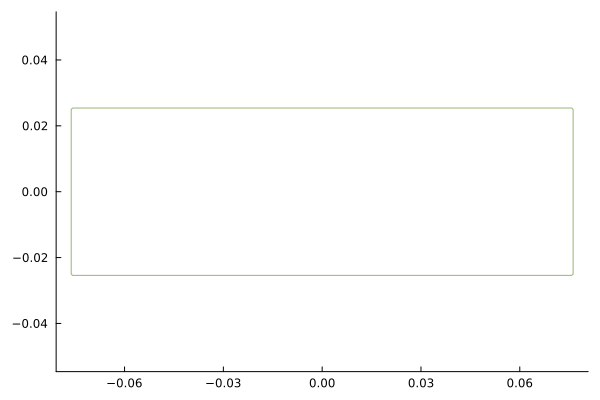

In [23]:
plot(body,fillalpha=0)

In [24]:
function get_qbplus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbplus = zeros_surface(base_cache)
    return qbplus
end

function get_qbminus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbminus = zeros_surface(base_cache)
    # qbminus .= nrm.u
    return qbminus
end

bcdict = Dict("exterior" => get_qbplus,"interior" => get_qbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_qbminus
  "exterior" => get_qbplus

  ### Set up the evaporators and condensers

  Right now, the OHPtype looks up a preset dictionary of OHP evaporators and
  condensers.

  You can also customize them in the OHP DIY notebook

In [25]:
function heatermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    σ .= phys_params["areaheater_power"] / phys_params["areaheater_area"] / phys_params["flux_correction"] 
end


function condensermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    T0 = phys_params["areaheater_temp"]
    h = phys_params["areaheater_coeff"]
    corr = phys_params["flux_correction"] 

    σ .= h*(T0 - T) / corr
end

condensermodel! (generic function with 1 method)

In [27]:
fregion1_h = Rectangle(0.5inches,1.0inches,1.4*Δx)
fregion2_h = deepcopy(fregion1_h)
tr1_h = RigidTransform((0.5inches,-0.0),0.0)
tr2_h = RigidTransform((-0.5inches,-0.0),0.0)

heater1 = AreaForcingModel(fregion1_h,tr1_h,heatermodel!);
heater2 = AreaForcingModel(fregion2_h,tr2_h,heatermodel!);

In [33]:
fregion1_c = Rectangle(0.5inches,0.0648*0.95/2,1.4*Δx)
fregion2_c = deepcopy(fregion1_c)
tr1_c = RigidTransform((2.5inches,-0.0),0.0)
tr2_c = RigidTransform((-2.5inches,-0.0),0.0)

cond1 = AreaForcingModel(fregion1_c,tr1_c,condensermodel!);
cond2 = AreaForcingModel(fregion2_c,tr2_c,condensermodel!);

  ### Set up OHP channel's shape

  constructohpcurve is a built-in function that generates two arrays: x that
  contains all x values of the discrete points, and y contains all y values. x
  and y have the same length.

  You can also customize this function to generate an OHP shape of your choice
  as long as they produce x array and y array.

In [34]:
x, y = construct_ohp_curve("ASETS",Δx) # get x and y coordinates for the channel
ohp = BasicBody(x,y) # build a BasicBody based on x,y

# fregion1 = Square(0.5,1.4*Δx)
tr_ohp = RigidTransform((0.0,0.0),0.0)

# phys_params["ohp_flux"] = zero(x);

function ohpmodel!(σ,T,t,fr::LineRegionCache,phys_params)
    σ .= phys_params["ohp_flux"] ./ phys_params["flux_correction"] 
end
ohp_linesource = LineForcingModel(ohp,tr_ohp,ohpmodel!);

  ### Plot what you got so far

  This is a exmaple of the compuational domain (the box) and the OHP channel
  serpentine (in blue)

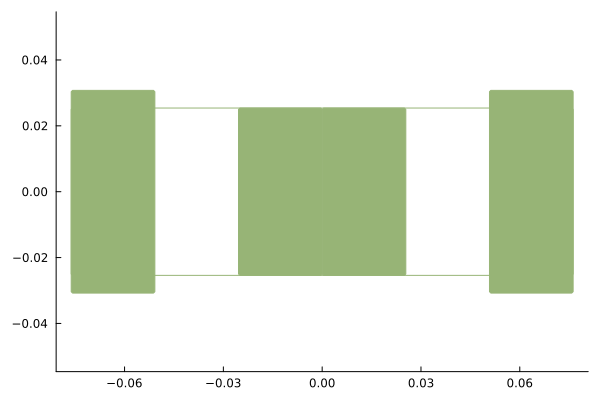

In [35]:
plot(body,fillalpha=0)
update_body!(fregion1_h,tr1_h)
update_body!(fregion2_h,tr2_h)
update_body!(fregion1_c,tr1_c)
update_body!(fregion2_c,tr2_c)
# update_body!(fregion3,tr3)
# update_body!(fregion4,tr4)
plot!(fregion1_h)
plot!(fregion1_c)
plot!(fregion2_h)
plot!(fregion2_c)
# plot!(fregion2)
# plot!(fregion3)
# plot!(fregion4)
# plot!(body,fillalpha=0)

In [36]:
forcing_dict = Dict("heating models" => [heater1,heater2,cond1,cond2,ohp_linesource])

Dict{String, Vector{AbstractForcingModel}} with 1 entry:
  "heating models" => [AreaForcingModel{Polygon{180, 4, ClosedBody}, MotionTran…

In [37]:
tspan = (0.0, 10.0); # start time and end time
dt_record = 0.05   # saving time interval

tstep = 1e-3     # actrual time marching step

0.001

In [38]:
timestep_fixed(u,sys) = tstep

timestep_fixed (generic function with 1 method)

In [39]:
prob = NeumannHeatConductionProblem(g,body,scaling=GridScaling,
                                             phys_params=phys_params,
                                             bc=bcdict,
                                             motions=m,
                                             forcing=forcing_dict,
                                             # timestep_func=timestep_fourier
                                             timestep_func=timestep_fixed
    );

  # Construct the systems

  ### Create HeatConduction system

  The solid module dealing with the 2D conduction, evaporator, condenser, and
  the OHP line heat source is constructed here.

In [40]:
sys_plate = construct_system(prob);

  ### Create OHP inner channel system

  sys_tube: fluid module system

In [41]:
sys_tube = initialize_ohpsys(sys_plate,p_fluid,power,inertia_f=1.3,slugnum=8)

5151 point OHP system filled with Butane


  # Initialize

  ### set time step

  ### combine inner tube and plate together

In [43]:
u_plate = init_sol(sys_plate)# initialize plate T field to uniform Tref
integrator_plate = init(u_plate,tspan,sys_plate,save_on=false) # construct integrator_plate

u_tube = newstate(sys_tube) # initialize OHP tube
integrator_tube = init(u_tube,tspan,sys_tube); # construct integrator_tube

### initialize arrays for saving

In [44]:
SimuResult = SimulationResult(integrator_tube,integrator_plate);

  # Solve

  ### Run the simulation and store data

In [45]:
@showprogress for t in tspan[1]:tstep:tspan[2]

      # phys_params["ohp_flux"] = integrator_plate
    timemarching!(integrator_tube,integrator_plate,tstep)
    # println()

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        store!(SimuResult,integrator_tube,integrator_plate)
    end

end

Progress:  15%|██████▍                                  |  ETA: 0:03:51

LoadError: InterruptException:

  # Store data

In [46]:
using JLD2

In [28]:
read_path = "../numedata/50s.jld2"
SimuResult = load(read_path,"SimulationResult");

In [32]:
using Statistics

In [33]:
mean(SimuResult.plate_T_hist[end])

297.02008866833603

In [383]:
save_path = "../numedata/50s.jld2"
save(save_path,"SimulationResult",SimuResult)

### take a peek at the solution (more at the PostProcessing notebook)

[ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/OscillatingHeatPipe/examples/tmp.gif


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/OscillatingHeatPipe/examples/tmp.gif")
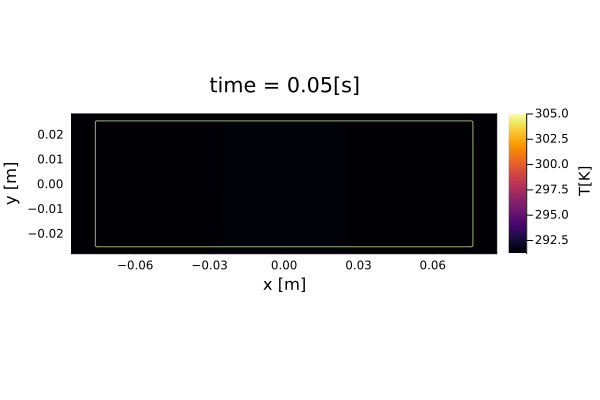

In [47]:
@gif for i in eachindex(SimuResult.tube_hist_t)
    # plot(OHPSlug(),i,SimuResult,aspectratio=1)
    plot(OHPTemp(),i,SimuResult,clim=(291.2,305.0))
    # plot(SimuResult.plate_T_hist[i],colorbar=true,fill=true)
    plot!(body,fillalpha=0)
end

[ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/OscillatingHeatPipe/examples/tmp.gif


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/OscillatingHeatPipe/examples/tmp.gif")
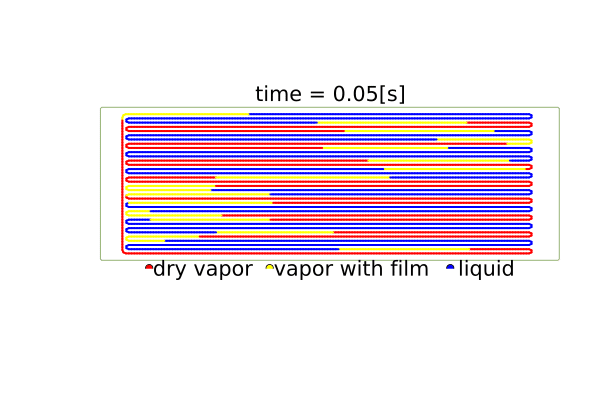

In [48]:
@gif for i in eachindex(SimuResult.tube_hist_t)
    plot(OHPSlug(),i,SimuResult,aspectratio=1)
    # plot(OHPTemp(),i,SimuResult,clim=(0.0,10.0))
    # plot(SimuResult.plate_T_hist[i],colorbar=true,fill=true)
    plot!(body,fillalpha=0)
end

In [120]:
x2Dsensors = [-2.75,-1.4,-0.8,0.0,0.0,0.8,1.4,2.75] .* inches
y2Dsensors = [0.0,   0.0, 0.0,0.0,0.4,0.0,0.0,0.0] .* inches
plate_sensors = (x2Dsensors,y2Dsensors);

In [121]:
t_hist,g_hist = getTcurve(plate_sensors,SimuResult);

In [122]:
import XLSX
expfile = expfileDict["O001_H001_P040"]
exppath = "../expdata/"
xf = XLSX.readxlsx(exppath*expfile);

In [123]:
Onum, Hnum, power_exp = getconfig(expfile)
RTDt,RTD = getRTD(xf,Onum);

In [124]:
RTD_for_plotting = [1,4,8];

In [46]:
plot(OHP(),SimuResult)

LoadError: Cannot convert LineForcingModel{BasicBody{5151, RigidBodyTools.ClosedBody}, MotionTransform{2}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, typeof(ohpmodel!)} to series data for plotting

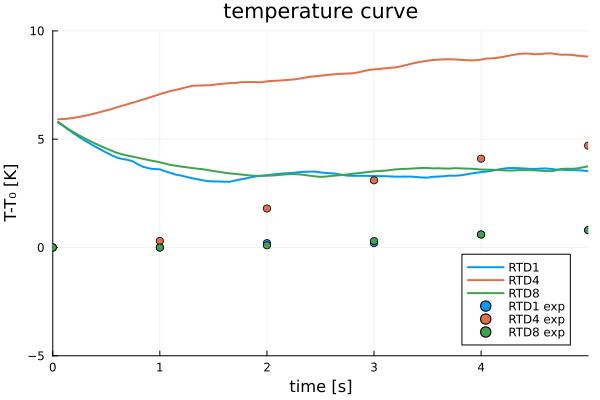

In [65]:
plot(OHPTcurve(),RTD_for_plotting,(t_hist,g_hist),SimuResult)
plot!(OHPTexp() ,RTD_for_plotting,(RTDt,RTD)     ,SimuResult,ylim=(-5,10))

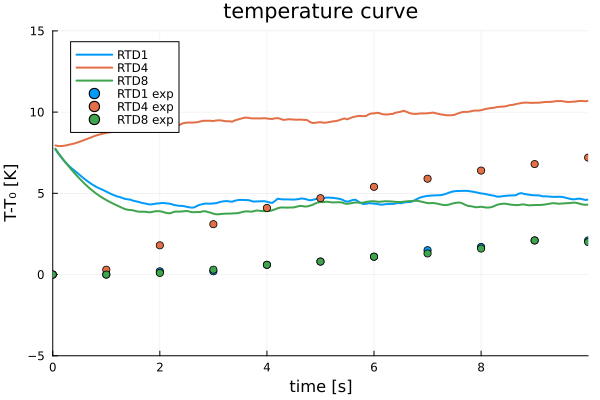

In [127]:
plot(OHPTcurve(),RTD_for_plotting,(t_hist,g_hist),SimuResult)
plot!(OHPTexp() ,RTD_for_plotting,(RTDt,RTD)     ,SimuResult,ylim=(-5,15))

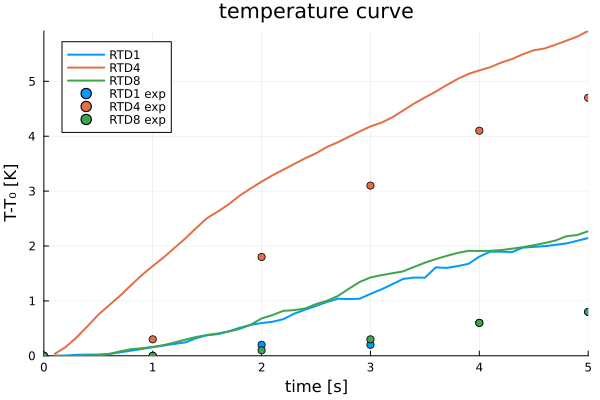

In [303]:
plot(OHPTcurve(),RTD_for_plotting,(t_hist,g_hist),SimuResult)
plot!(OHPTexp() ,RTD_for_plotting,(RTDt,RTD)     ,SimuResult)

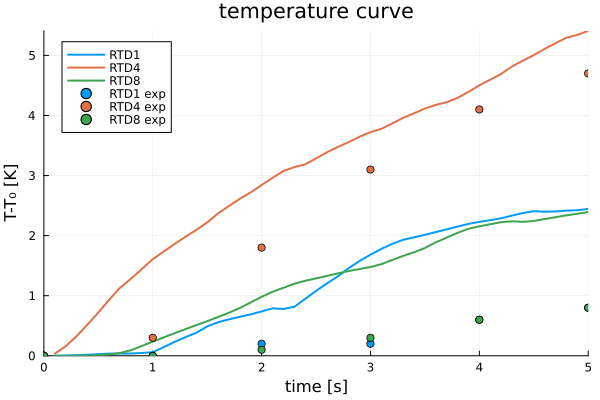

In [318]:
plot(OHPTcurve(),RTD_for_plotting,(t_hist,g_hist),SimuResult)
plot!(OHPTexp() ,RTD_for_plotting,(RTDt,RTD)     ,SimuResult)

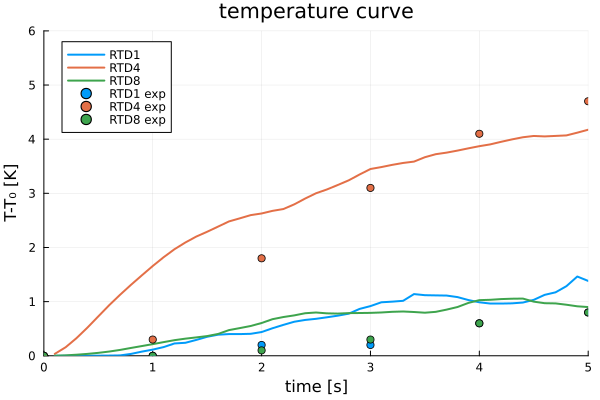

In [359]:
plot(OHPTcurve(),RTD_for_plotting,(t_hist,g_hist),SimuResult)
plot!(OHPTexp() ,RTD_for_plotting,(RTDt,RTD)     ,SimuResult,ylim=(0,6))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*

In [584]:
# import XLSX
# expfile2 = "T01_H06_C18x2_S06.xlsx"
# exppath = "../expdata/"
# xf2 = XLSX.readxlsx(exppath*expfile2);


In [585]:
# RTD2 = Float64.(xf2["TC Data!C2:Z134886"]);
# RTDt2 = Float64.(xf2["TC Data!B2:B134886"]);

In [586]:
# istart = 3600
# iend = 5000
# plot(RTDt2[istart:iend],RTD2[istart:iend,4])
# plot!(RTDt2[istart:iend],RTD2[istart:iend,1],ylim=(18,18+15))

In [587]:
randomXp(tube::Tube;numofslugs=30,chargeratio=0.46,σ_charge=0.1)


LoadError: UndefVarError: `tube` not defined

In [588]:
Xp,dXdt = randomXp(1000.0,1e-2,true,numofslugs=100)

([(372.7003163881134, 374.55518141849046), (382.7003163881134, 391.25070722515665), (392.7003163881134, 401.3611283211295), (402.7003163881134, 403.71590371785635), (412.7003163881134, 412.74134081854424), (422.7003163881134, 426.1088099815056), (432.7003163881134, 436.1051728314553), (442.7003163881134, 451.8858744165177), (452.7003163881134, 457.72723088942416), (462.7003163881134, 466.05374344400656)  …  (272.7003163881134, 279.07480342950066), (282.7003163881134, 290.4217601609812), (292.7003163881134, 294.40252794514845), (302.7003163881134, 312.0854779322949), (312.7003163881134, 318.7756334030678), (322.7003163881134, 331.5335302013543), (332.7003163881134, 334.2124484620267), (342.7003163881134, 347.53120999012117), (352.7003163881134, 354.38335416410814), (362.7003163881134, 363.07002338513894)], [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)  …  (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0),

In [589]:
@time s = XMtovec(Xp,dXdt,zeros(size(Xp)));

LoadError: MethodError: no method matching XMtovec(::Vector{Tuple{Float64, Float64}}, ::Vector{Tuple{Float64, Float64}}, ::Vector{Float64})

In [590]:
@time Xps = hcat(first.(Xp),last.(Xp));
@time vcat(Xps'...)

  0.000018 seconds (5 allocations: 3.547 KiB)
  0.000136 seconds (880 allocations: 35.672 KiB)


200-element Vector{Float64}:
 372.7003163881134
 374.55518141849046
 382.7003163881134
 391.25070722515665
 392.7003163881134
 401.3611283211295
 402.7003163881134
 403.71590371785635
 412.7003163881134
 412.74134081854424
 422.7003163881134
 426.1088099815056
 432.7003163881134
   ⋮
 312.7003163881134
 318.7756334030678
 322.7003163881134
 331.5335302013543
 332.7003163881134
 334.2124484620267
 342.7003163881134
 347.53120999012117
 352.7003163881134
 354.38335416410814
 362.7003163881134
 363.07002338513894

In [591]:
@time XptoLliquidslug(Xp::Vector{Tuple{Float64, Float64}},4.66::Float64)

  0.000004 seconds (1 allocation: 896 bytes)


100-element Vector{Float64}:
 1.8548650303770842
 3.8903908370432667
 4.000811933016134
 1.0155873297429707
 0.04102443043086623
 3.4084935933922225
 3.4048564433419415
 4.52555802840433
 0.3669145013107844
 3.353427055893178
 4.560802910622353
 2.683610631313538
 2.7397919889534386
 ⋮
 3.8951536119759567
 2.5667366378118004
 1.714487041387283
 3.0614437728678148
 1.7022115570350707
 0.06516154418152809
 1.4153170149544074
 4.173213813240945
 1.5121320739133353
 0.1708936020077907
 1.6830377759947623
 0.36970699702555976

In [592]:
@time XptoLvaporplug(Xp::Vector{Tuple{Float64, Float64}},4.66::Float64,true::Bool)

  0.000003 seconds (1 allocation: 896 bytes)


100-element Vector{Float64}:
 0.31029300297443996
 3.4851349696229157
 1.4496091629567331
 1.3391880669838656
 4.324412670257029
 0.6389755695691335
 1.9315064066077774
 1.9351435566580584
 0.8144419715956701
 0.3130854986892153
 1.9865729441068218
 0.7791970893776465
 2.6563893686864617
 ⋮
 1.0313992662411238
 1.4448463880240432
 2.7732633621881995
 3.625512958612717
 2.278556227132185
 3.637788442964929
 0.6148384558184716
 3.9246829850455924
 1.1667861867590545
 3.8278679260866646
 0.509106397992209
 3.6569622240052375

In [593]:
@time first.(Xp)


  0.000006 seconds (2 allocations: 912 bytes)


100-element Vector{Float64}:
 372.7003163881134
 382.7003163881134
 392.7003163881134
 402.7003163881134
 412.7003163881134
 422.7003163881134
 432.7003163881134
 442.7003163881134
 452.7003163881134
 462.7003163881134
 472.7003163881134
 482.7003163881134
 492.7003163881134
   ⋮
 252.70031638811338
 262.7003163881134
 272.7003163881134
 282.7003163881134
 292.7003163881134
 302.7003163881134
 312.7003163881134
 322.7003163881134
 332.7003163881134
 342.7003163881134
 352.7003163881134
 362.7003163881134

In [594]:
Xp = 
XMtovec(Xp::Array{Tuple{Float64,Float64},1},dXdt::Array{Tuple{Float64,Float64},1},M::Array{Float64,1})

LoadError: UndefVarError: `M` not defined

In [544]:
function Xtovec(Xp,dXdt)
    first.(dXdt)
end

Xtovec (generic function with 1 method)